<a href="https://colab.research.google.com/github/sandhrabijoy/_/blob/master/ARIMA_SARIMA_%26_FBPROPHET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sweetviz
import sweetviz as sv
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 62.9 MB/s eta 0:00:00


In [8]:
df= pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


Start to Clean and read Data

In [9]:
report = sv.analyze(df)
report.show_html('report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [11]:
def comprehensive_df_overview(dataframe):
  print("##### Shape")
  print(dataframe.shape)
  print("\n##### Data Types")
  print(dataframe.dtypes)
  print("\n###### Columns")
  print(dataframe.columns)
  print("\n##### Index")
  print(dataframe.index)
  print("\n##### Head")
  print(dataframe.head())
  print("\n##### Tail")
  print(dataframe.tail())
  print("\n##### NA")
  print(dataframe.isnull().values.any())
  print("\n###### NA Sum - Ratio")
  print(pd.DataFrame({"na_sum":dataframe.isnull().sum(),"ratio":dataframe.isnull().sum()/dataframe.shape[0]}))
  numeric_cols= dataframe.select_dtypes(include=['number']).columns
  if not numeric_cols.empty:
    print('\n###### Basic Statistics (Numeric Columns)')
    print(dataframe[numeric_cols].describe().T)
    print("\n##### Skewness (Numeric Columns)")
    print(dataframe[numeric_cols].skew())
    print("\n##### Kurtosis (Numeric Columns)")
    print(dataframe[numeric_cols].kurtosis())
    print("\n##### Correlation Matrix (Numeric Columns)")
    print(dataframe[numeric_cols].corr())
  else:
    print("\nNO numeric columns found for statistical analysis")
    non_numeric_cols=dataframe.select_dtypes(exclude=['number']).columns
    if not non_numeric_cols.empty:
      print("\n##### Basic Statistics (Non Numeric Columns)")
      print(dataframe[non_numeric_cols].describe().T)
    else:
      print("\nNo non-numeric columns found for statistical analysis")
    print("\n##### Unique Values per Column")
    print(dataframe.nunique())
    print("\n##### Sample Rows")
    print(dataframe.sample(5))
    print("\n##### Memory Usage")
    print(dataframe.memory_usage(deep=True))

comprehensive_df_overview(df)

##### Shape
(9800, 18)

##### Data Types
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

###### Columns
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

##### Index
RangeIndex(start=0, stop=9800, step=1)

##### Head
   Row ID        Order ID  ...                                       Product Name     Sales
0       1  CA-2017-152156  ...                 

In [12]:
df=df.drop(columns=["Row ID","Order ID", "Ship Date", "Customer Name", "Country", "Postal Code", "Product Name"])
df.head()

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680


In [15]:
from scipy import stats

def handle_outliers(df, column, threshold=3):
    # Use zscore to calculate z-scores
    z_scores = np.abs(stats.zscore(df[[column]].dropna()))
    # Filter rows based on the threshold
    df = df[(z_scores < threshold).all(axis=1)]
    return df


In [16]:
df=handle_outliers(df,"Sales")

In [17]:
df

,Order Date,Ship Mode,Customer ID,Segment,City,State,Region,Product ID,Category,Sub-Category,Sales
0,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,08/11/2017,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,731.9400
2,12/06/2017,Second Class,DV-13045,Corporate,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,957.5775
4,11/10/2016,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,22.3680
...,...,...,...,...,...,...,...,...,...,...,...
9795,21/05/2017,Standard Class,SH-19975,Corporate,Chicago,Illinois,Central,OFF-BI-10003429,Office Supplies,Binders,3.7980
9796,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,OFF-AR-10001374,Office Supplies,Art,10.3680
9797,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10004977,Technology,Phones,235.1880
9798,12/01/2016,Standard Class,CS-12490,Corporate,Toledo,Ohio,East,TEC-PH-10000912,Technology,Phones,26.3760


Prepare for Time Series

In [20]:
def prepare_for_timeseries(dataframe):
  dataframe['Order Date']=pd.to_datetime(dataframe['Order Date'], format='%d%m%Y',errors='coerce')
  dataframe=dataframe.sort_values(by='Order Date')
  dataframe.reset_index(drop=True,inplace=True)
  print("##### Data Preparation Completed")
  print("\n##### Sorted DataFrame Head")
  print(dataframe.head())

  return dataframe

df = prepare_for_timeseries(df)


##### Data Preparation Completed

##### Sorted DataFrame Head
  Order Date       Ship Mode Customer ID  ...         Category Sub-Category     Sales
0        NaT    Second Class    CG-12520  ...        Furniture    Bookcases  261.9600
1        NaT    Second Class    CG-12520  ...        Furniture       Chairs  731.9400
2        NaT    Second Class    DV-13045  ...  Office Supplies       Labels   14.6200
3        NaT  Standard Class    SO-20335  ...        Furniture       Tables  957.5775
4        NaT  Standard Class    SO-20335  ...  Office Supplies      Storage   22.3680

[5 rows x 11 columns]


Exploring Data:Numerical,Categorical

In [25]:
def fetch_col_names(dataframe):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O' and not np.issubdtype(dataframe[col].dtype, np.datetime64)]
    return cat_cols, num_cols

cat_cols, num_cols = fetch_col_names(df)


In [28]:
cat_cols


['Ship Mode',
 'Customer ID',
 'Segment',
 'City',
 'State',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category']

In [29]:
num_cols

['Sales']

In [32]:
def cat_details(dataframe,col_name, plot=False):
  #Count and ration of unique values
  value_counts= dataframe[col_name].value_counts()
  ratio =100 * value_counts/len(dataframe)
  #Length of Summary Line
  summary_length=len(col_name)+len(" Details ")
  border_length=max(50,summary_length + 4)

  #creation of border lines
  top_border = '#'* border_length
  middle_border=f"{'#'*10}{col_name} Details {'#'*10}".center(border_length,'#')
  bottom_border='#'* border_length

  #print summary
  print(f"\n{top_border}")
  print(middle_border)
  print(pd.DataFrame({col_name:value_counts,"Ratio(%)":ratio}))
  print(f"\n{col_name} has {dataframe[col_name].nunique()} unique values.")
  print(f"{bottom_border}\n")

  #Plot countplot if plot is true
  if plot:
    plt.figure(figsize=(10,6))
    plt.bar(value_counts.index, value_counts.values)

    plt.title(f"Count Plot for {col_name}")
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()




##################################################
################Ship Mode Details ################
                Ship Mode   Ratio(%)
Ship Mode                           
Standard Class       5788  59.811925
Second Class         1877  19.396507
First Class          1481  15.304330
Same Day              531   5.487238

Ship Mode has 4 unique values.
##################################################



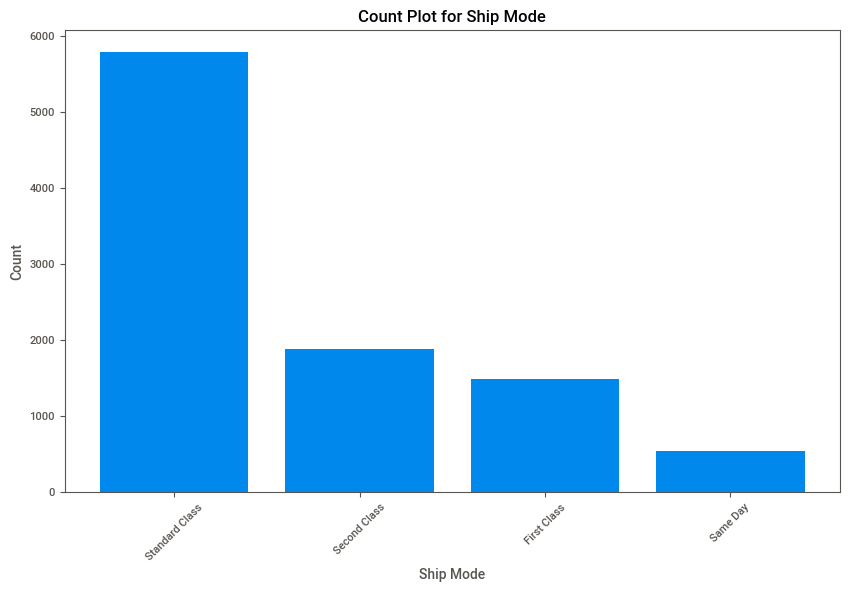


##################################################
#################Segment Details #################
             Segment   Ratio(%)
Segment                        
Consumer        5041  52.092591
Corporate       2917  30.143640
Home Office     1719  17.763770

Segment has 3 unique values.
##################################################



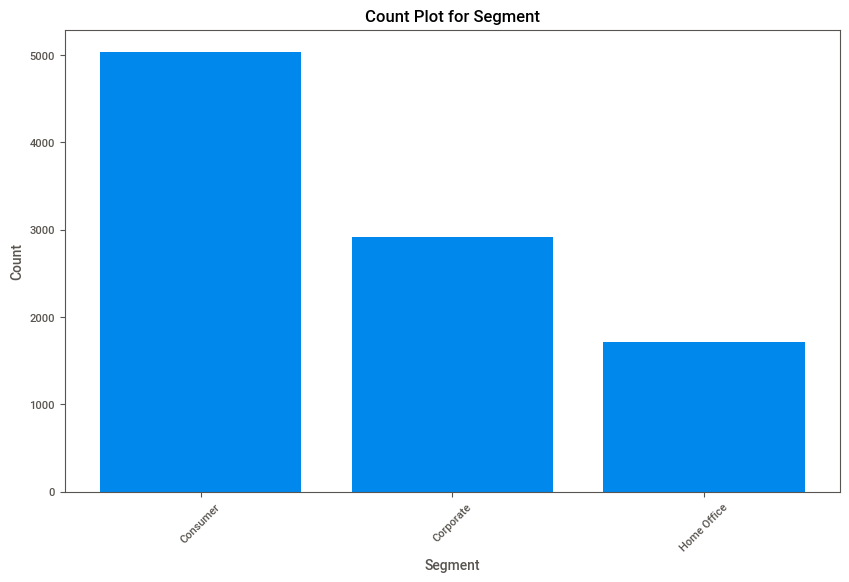


##################################################
##################State Details ##################
                      State   Ratio(%)
State                                 
California             1923  19.871861
New York               1070  11.057146
Texas                   965   9.972099
Pennsylvania            578   5.972925
Washington              496   5.125555
Illinois                481   4.970549
Ohio                    453   4.681203
Florida                 370   3.823499
Michigan                248   2.562778
North Carolina          244   2.521443
Arizona                 223   2.304433
Virginia                218   2.252764
Tennessee               181   1.870414
Colorado                178   1.839413
Georgia                 173   1.787744
Massachusetts           135   1.395060
Kentucky                134   1.384727
Indiana                 133   1.374393
Oregon                  122   1.260721
New Jersey              118   1.219386
Maryland                104   1.074713


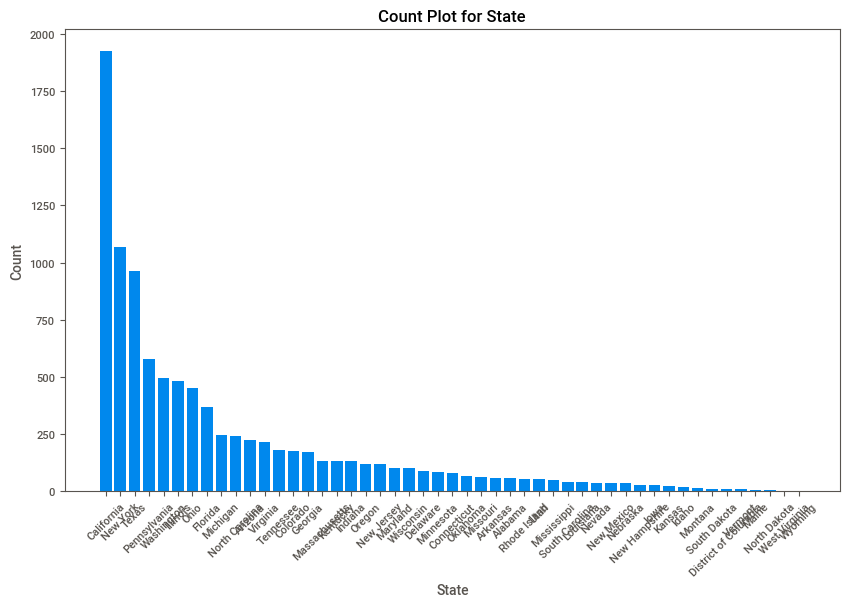


##################################################
#################Region Details ##################
         Region   Ratio(%)
Region                    
West       3105  32.086390
East       2743  28.345562
Central    2254  23.292343
South      1575  16.275705

Region has 4 unique values.
##################################################



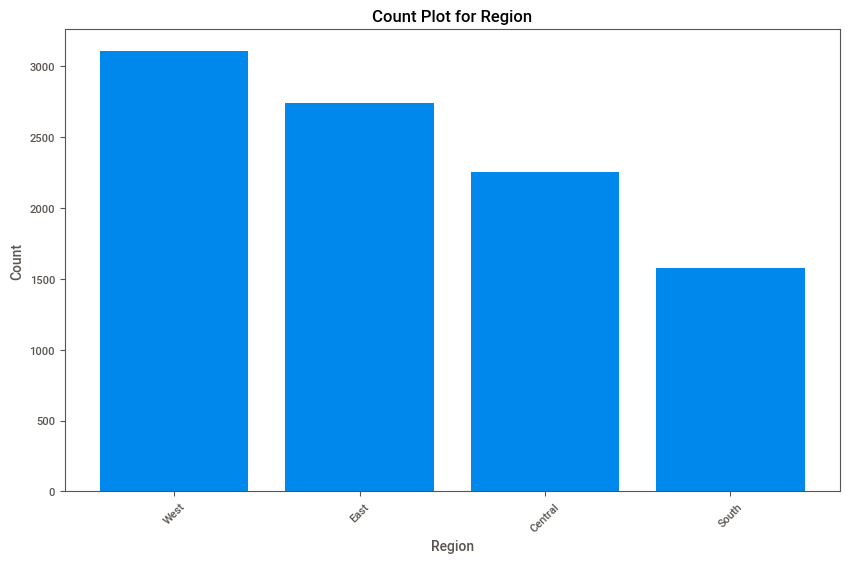


##################################################
################Category Details #################
                 Category   Ratio(%)
Category                            
Office Supplies      5880  60.762633
Furniture            2046  21.142916
Technology           1751  18.094451

Category has 3 unique values.
##################################################



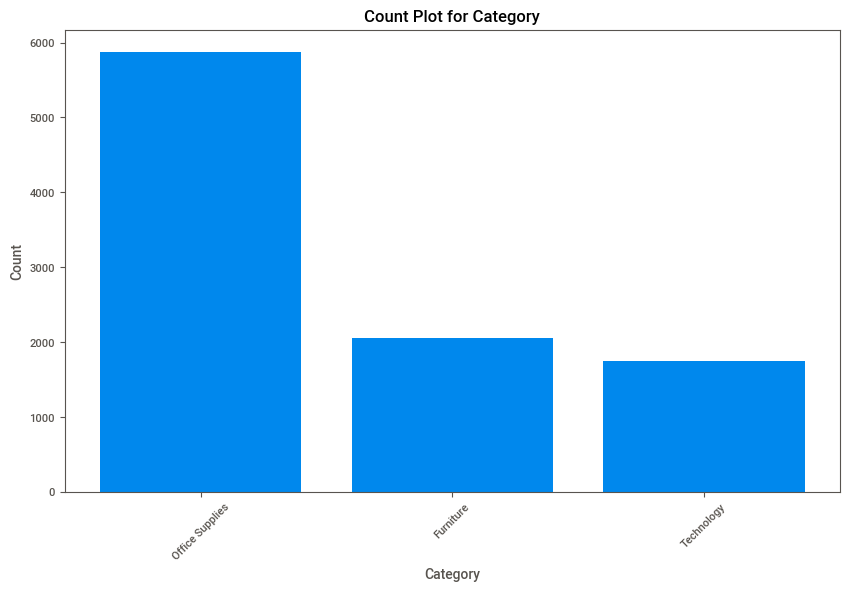


##################################################
##############Sub-Category Details ###############
              Sub-Category   Ratio(%)
Sub-Category                         
Binders               1474  15.231993
Paper                 1338  13.826599
Furnishings            931   9.620750
Phones                 864   8.928387
Storage                830   8.577038
Art                    785   8.112018
Accessories            752   7.771003
Chairs                 592   6.117598
Appliances             456   4.712204
Labels                 357   3.689160
Tables                 304   3.141469
Envelopes              248   2.562778
Bookcases              219   2.263098
Fasteners              214   2.211429
Supplies               178   1.839413
Machines                86   0.888705
Copiers                 49   0.506355

Sub-Category has 17 unique values.
##################################################



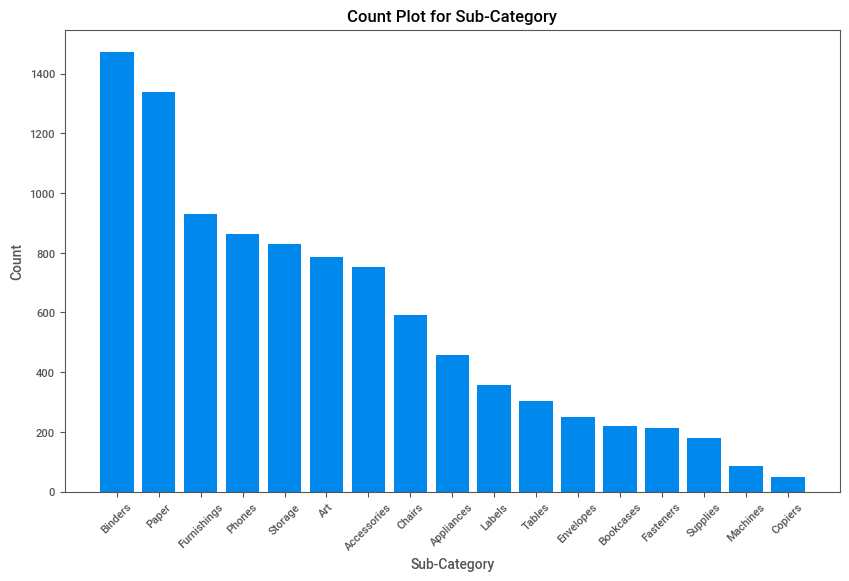

In [33]:
for col in ["Ship Mode", "Segment", "State", "Region", "Category", "Sub-Category"]:
  cat_details(df,col,plot=True)